In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Load the dataset
train_data = pd.read_csv("./poker-hand-training-true.data", header=None)
test_data = pd.read_csv("./poker-hand-testing.data", header=None)

# Rename columns
columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'CLASS']
train_data.columns = columns
test_data.columns = columns

# Feature Engineering: Adding new features based on rank and suit counts, flags for flush and straight
def add_features(df):
    df['is_flush'] = df.apply(lambda row: len(set([row['S1'], row['S2'], row['S3'], row['S4'], row['S5']])) == 1, axis=1)
    df['is_straight'] = df.apply(lambda row: sorted([row['C1'], row['C2'], row['C3'], row['C4'], row['C5']]) == list(range(min([row['C1'], row['C2'], row['C3'], row['C4'], row['C5']]), min([row['C1'], row['C2'], row['C3'], row['C4'], row['C5']]) + 5)), axis=1)
    return df

# Apply feature engineering to train and test data
train_data = add_features(train_data)
test_data = add_features(test_data)

# Separate features and target
X_train = train_data.drop(columns=['CLASS'])
y_train = train_data['CLASS']
X_test = test_data.drop(columns=['CLASS'])
y_test = test_data['CLASS']

# Define the model with hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_rf_model = grid_search.best_estimator_

# Evaluate on test data
y_pred_test = best_rf_model.predict(X_test)
print("Classification Report for Tuned Random Forest Model:")
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))

# Define a dictionary to map class labels to poker hand names
class_labels = {
    0: "Nothing in hand",
    1: "One pair",
    2: "Two pairs",
    3: "Three of a kind",
    4: "Straight",
    5: "Flush",
    6: "Full house",
    7: "Four of a kind",
    8: "Straight flush",
    9: "Royal flush"
}

# Function to predict and interpret the result
def classify_poker_hand(model, hand):
    prediction = model.predict([hand])[0]
    return class_labels[prediction]

# Suppress feature name warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but RandomForestClassifier was fitted with feature names")


Classification Report for Tuned Random Forest Model:
              precision    recall  f1-score   support

           0       0.63      0.80      0.70    501209
           1       0.57      0.48      0.52    422498
           2       0.30      0.01      0.01     47622
           3       0.46      0.01      0.01     21121
           4       1.00      0.90      0.95      3885
           5       1.00      1.00      1.00      1996
           6       0.00      0.00      0.00      1424
           7       0.00      0.00      0.00       230
           8       1.00      1.00      1.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.61   1000000
   macro avg       0.50      0.42      0.42   1000000
weighted avg       0.59      0.61      0.58   1000000

Accuracy: 0.609782


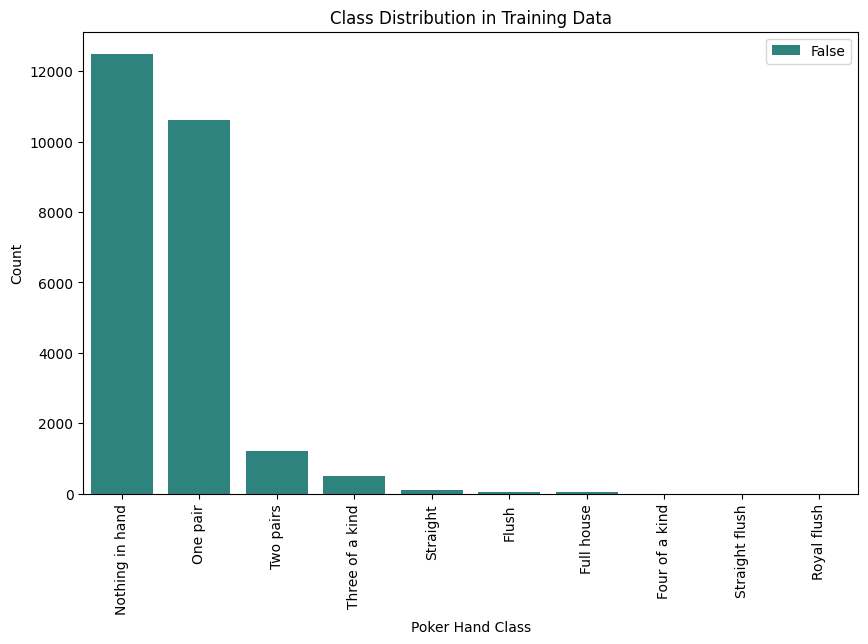

In [2]:
# 1. Plot Class Distribution in the Dataset
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, palette="viridis", hue=False)
plt.title("Class Distribution in Training Data")
plt.xlabel("Poker Hand Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels.values(), rotation=90)
plt.show()


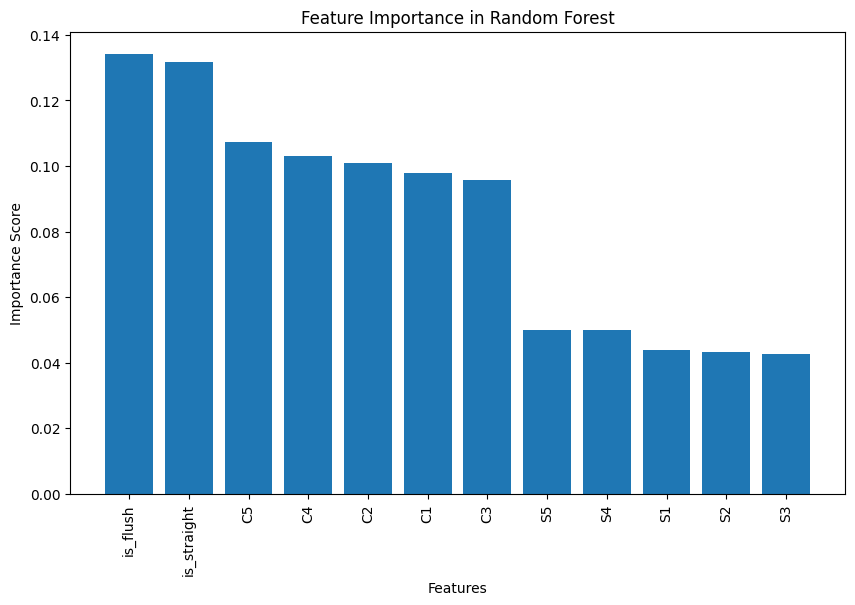

In [3]:
# 2. Plot Feature Importance
feature_importances = best_rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

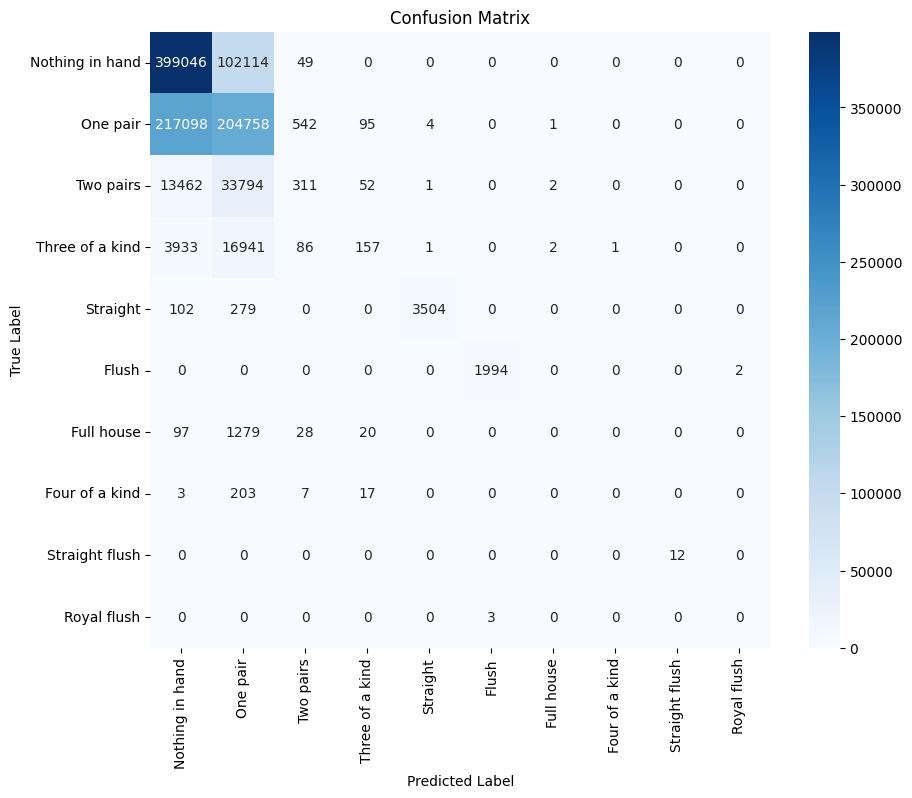

In [4]:
# 3. Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


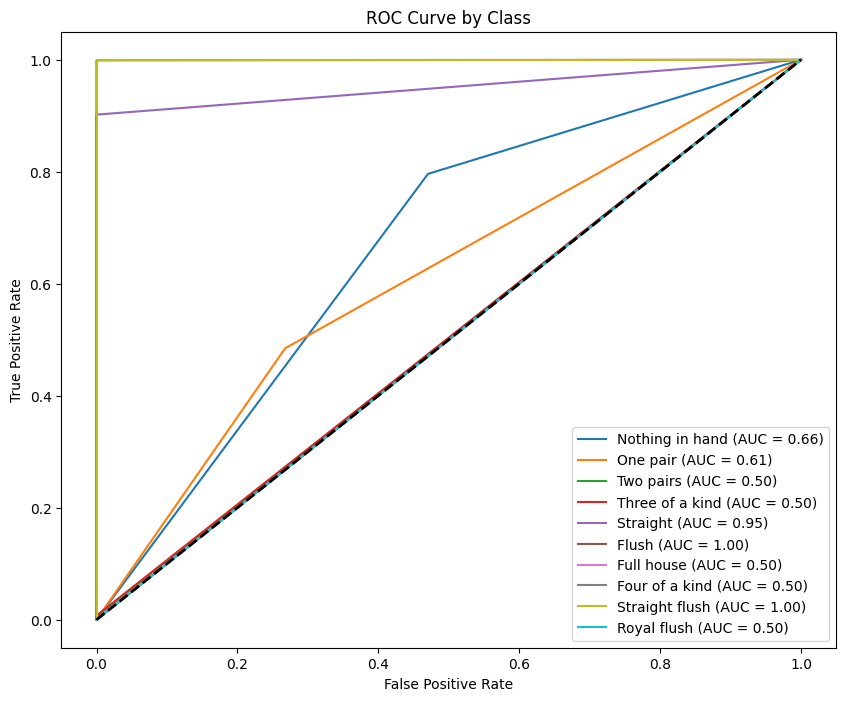

In [5]:
# 4. Plot ROC Curve for Each Class
y_test_bin = label_binarize(y_test, classes=np.arange(10))  # Binarize labels for multi-class ROC
y_pred_bin = label_binarize(y_pred_test, classes=np.arange(10))

plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve by Class")
plt.legend(loc="best")
plt.show()

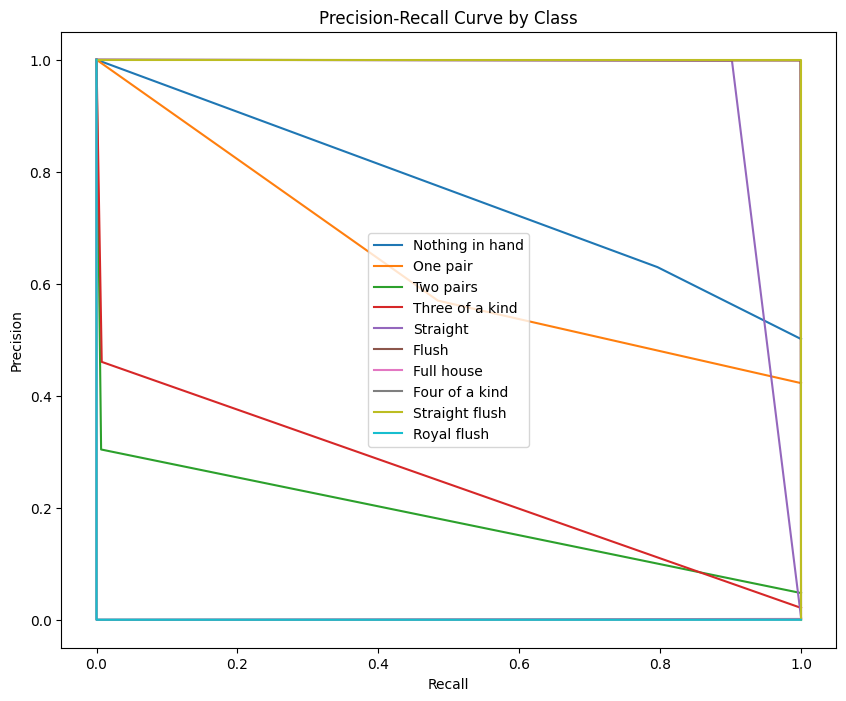

In [6]:
# 5. Plot Precision-Recall Curve for Each Class
plt.figure(figsize=(10, 8))
for i in range(10):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, label=class_labels[i])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve by Class")
plt.legend(loc="best")
plt.show()

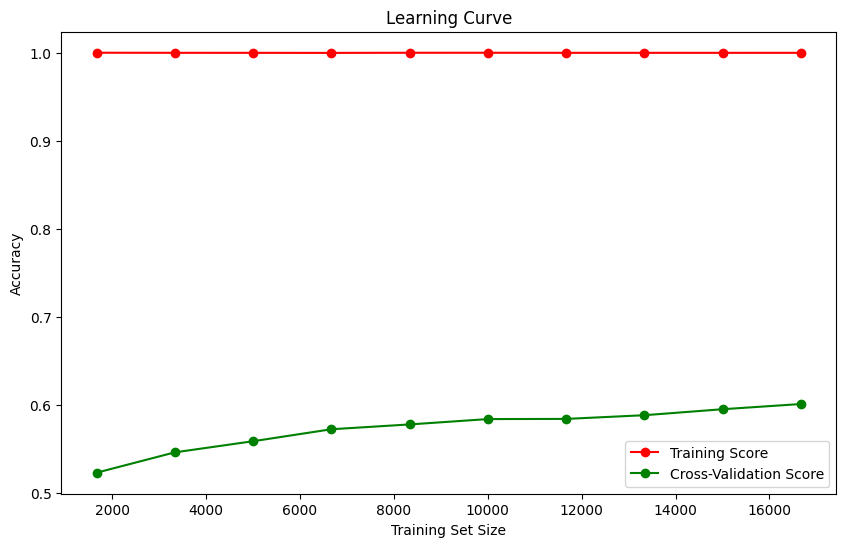

In [7]:
# 6. Plot Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_rf_model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

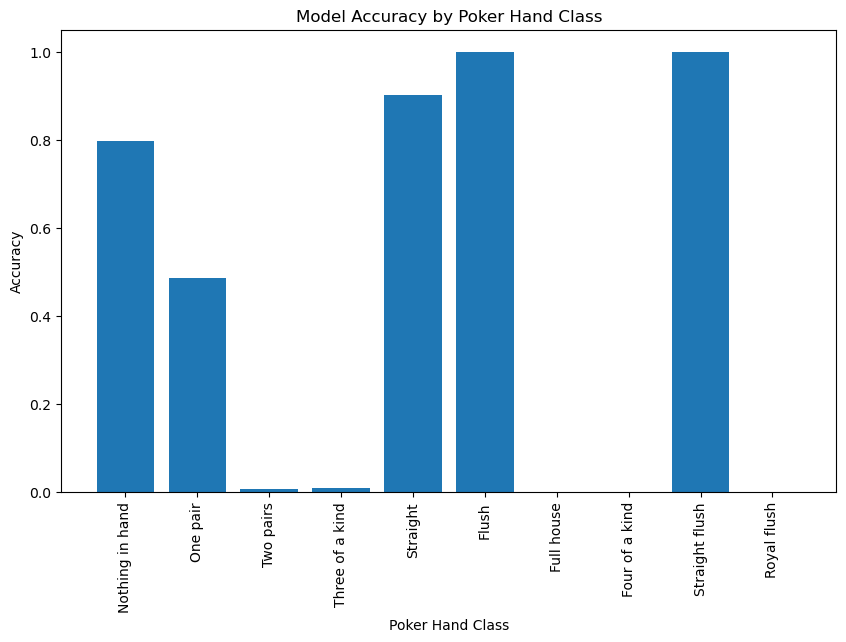

In [33]:
# 7. Plot Accuracy by Class
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(class_labels.values(), accuracy_per_class)
plt.xticks(rotation=90)
plt.xlabel("Poker Hand Class")
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Poker Hand Class")
plt.show()

In [35]:
# Sample hands to test with feature names
sample_hands = {
    "Nothing in hand": [1, 3, 2, 5, 3, 7, 4, 10, 4, 12, 0, 0],  # Random cards, no specific pattern
    "One Pair": [2, 4, 3, 4, 1, 9, 4, 6, 2, 10, 0, 0],          # One pair of 4s
    "Two Pairs": [1, 8, 3, 8, 2, 11, 4, 11, 1, 5, 0, 0],        # Two pairs: 8s and 11s
    "Three of a Kind": [2, 7, 3, 7, 1, 7, 4, 5, 2, 9, 0, 0],    # Three 7s
    "Straight": [1, 9, 2, 10, 3, 11, 4, 12, 2, 13, 0, 1],       # Straight from 9 to King
    "Flush": [1, 2, 1, 5, 1, 7, 1, 10, 1, 13, 1, 0],            # All hearts, so it's a Flush
    "Full House": [3, 5, 1, 6, 4, 6, 2, 9, 3, 9, 0, 0],         # Three 6s and two 9s
    "Four of a Kind": [2, 3, 3, 3, 1, 3, 4, 3, 1, 7, 0, 0],     # Four 3s
    "Straight Flush": [4, 5, 4, 6, 4, 7, 4, 8, 4, 9, 1, 1],     # Straight flush in clubs from 5 to 9
    "Royal Flush": [1, 10, 1, 11, 1, 12, 1, 13, 1, 1, 1, 1]     # Royal Flush in hearts
}

# Define column names including the extra features for flush and straight
feature_columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'is_flush', 'is_straight']

# Test each sample hand and print the prediction with feature names
print("\nPredictions for Various Sample Hands:")
for hand_name, hand in sample_hands.items():
    hand_df = pd.DataFrame([hand], columns=feature_columns)  # Add feature names
    predicted_hand = classify_poker_hand(best_rf_model, hand_df.values[0])
    print(f"Test Hand: {hand_name} -> Predicted: {predicted_hand}")


Predictions for Various Sample Hands:
Test Hand: Nothing in hand -> Predicted: Nothing in hand
Test Hand: One Pair -> Predicted: One pair
Test Hand: Two Pairs -> Predicted: One pair
Test Hand: Three of a Kind -> Predicted: One pair
Test Hand: Straight -> Predicted: Straight
Test Hand: Flush -> Predicted: Flush
Test Hand: Full House -> Predicted: One pair
Test Hand: Four of a Kind -> Predicted: One pair
Test Hand: Straight Flush -> Predicted: Straight flush
Test Hand: Royal Flush -> Predicted: Royal flush
